In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import plotly
plotly.offline.init_notebook_mode(connected=False)
import plotly.offline as py
import plotly.graph_objs as go

In [3]:


installs = pd.read_csv('installs.csv')
installs["created"] =  pd.to_datetime(installs["created"], errors = "coerce") #parseo de fechas
installs.drop('attributed', axis = 1, inplace = True) #son todas false
installs.drop('click_hash', axis = 1, inplace = True) #son todas NaN

In [4]:
clicks_dtypes = {'advertiser': np.int8, 'action_id': np.float16, 'source_id': np.int8, 'country_code': 'category',
                 'latitude': np.float16, 'longitude': np.float16, 'carrier_id': np.float16, 'brand': np.float16,
                 'touchX': np.float16, 'touchY': np.float16}

clicks = pd.read_csv('clicks.csv', dtype = clicks_dtypes)
clicks["created"] =  pd.to_datetime(clicks["created"], errors = "coerce") #parseo de fechas
clicks.drop('action_id', axis = 1, inplace = True) #todos NaN
clicks.drop('wifi_connection', axis = 1, inplace = True) #todos False

In [5]:
events = pd.read_csv('events.csv', low_memory=False)

events["date"] =  pd.to_datetime(events["date"], errors = "coerce")

In [6]:
auctions = pd.read_csv('auctions.csv')
auctions["date"] =  pd.to_datetime(auctions["date"], errors = "coerce")
auctions.drop('auction_type_id', axis = 1, inplace = True)  #todas Nan

In [7]:
installs.columns

Index(['created', 'application_id', 'ref_type', 'ref_hash', 'implicit',
       'device_countrycode', 'device_brand', 'device_model',
       'session_user_agent', 'user_agent', 'event_uuid', 'kind', 'wifi',
       'trans_id', 'ip_address', 'device_language'],
      dtype='object')

In [8]:
events.columns

Index(['date', 'event_id', 'ref_type', 'ref_hash', 'application_id',
       'attributed', 'device_countrycode', 'device_os_version', 'device_brand',
       'device_model', 'device_city', 'session_user_agent', 'trans_id',
       'user_agent', 'event_uuid', 'carrier', 'kind', 'device_os', 'wifi',
       'connection_type', 'ip_address', 'device_language'],
      dtype='object')

In [9]:
auctions.columns

Index(['country', 'date', 'device_id', 'platform', 'ref_type_id', 'source_id'], dtype='object')

In [10]:
clicks.columns

Index(['advertiser_id', 'source_id', 'created', 'country_code', 'latitude',
       'longitude', 'carrier_id', 'trans_id', 'os_minor', 'agent_device',
       'os_major', 'specs_brand', 'brand', 'timeToClick', 'touchX', 'touchY',
       'ref_type', 'ref_hash'],
      dtype='object')

In [11]:
def obtener_grafo(df):
    df_from = []
    df_to = []
    last_event = None
    last_ref = None
    for a,row in df.iterrows():
        event = row["event_id"]
        ref = row["ref_hash"]
        
        if ref != last_ref:
            event == None
        elif(event and event != last_event):
            df_from.append(last_event)
            df_to.append(event)
        
        last_ref = ref
        last_event = event
    return pd.DataFrame({"from":df_from,"to":df_to}).drop_duplicates()
        

In [12]:
grafo_eventos = events.loc[events['ref_hash'].isin(installs["ref_hash"].unique()),["date","event_id","ref_hash"]]
grafo_eventos.sort_values("date",inplace=True)
grafo_eventos.sort_values("ref_hash",inplace=True)
grafo_eventos_aristas = obtener_grafo(grafo_eventos)
grafo_eventos_aristas.head(3)

from  to
0    82   1
1     1  82
2    82  81

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



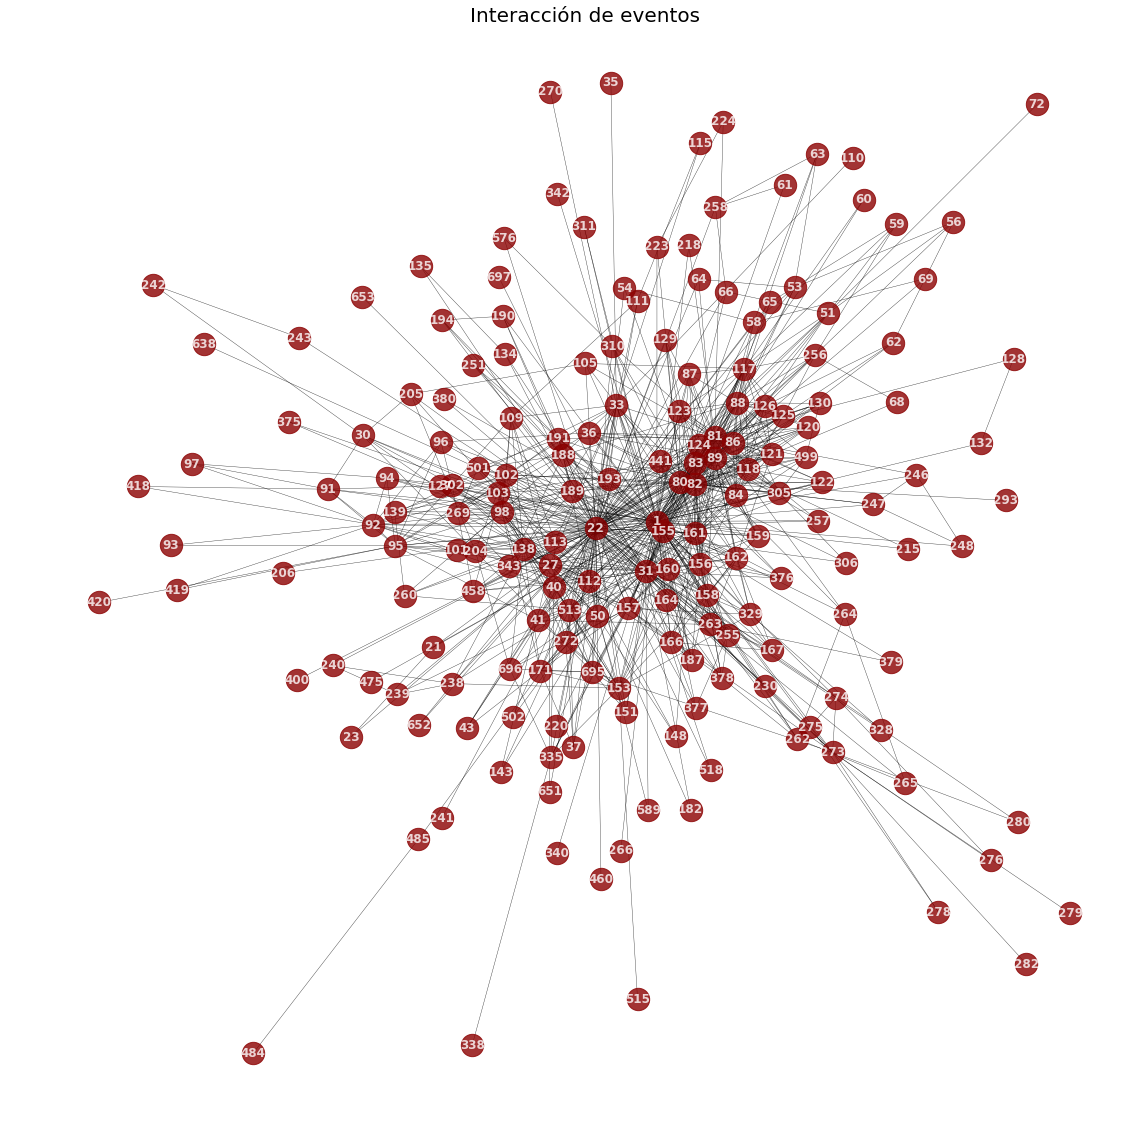

In [13]:
import networkx as nx
 
G=nx.from_pandas_edgelist(grafo_eventos_aristas, 'from', 'to')
plt.figure(figsize=(15,15)) 
nx.draw(G, alpha=0.8, node_size=500, width=0.4, node_color="darkred",font_color="white", font_weight="bold",with_labels=True)
plt.title("Interacción de eventos",size=20)
plt.show()

In [33]:
cant_horas_anteriores = 72
installs_to_join = installs.loc[:, ["ref_hash","application_id","created"]]
installs_to_join = installs_to_join.groupby(["ref_hash","application_id"]).agg({"created":"min"})
installs_to_join["fecha_fin_de_datos"] = pd.to_datetime("2019-03-14")
installs_to_join["diff"] = (installs_to_join["fecha_fin_de_datos"] - installs_to_join["created"]) / np.timedelta64(1, 'h')
installs_to_join = installs_to_join.loc[installs_to_join["diff"] > cant_horas_anteriores]
installs_to_join.head()

created fecha_fin_de_datos  \
ref_hash          application_id                                              
4958526679100225  10             2019-03-09 15:24:03.123         2019-03-14   
5610335643679608  7              2019-03-08 23:56:00.134         2019-03-14   
17437441331211593 16             2019-03-08 23:13:00.326         2019-03-14   
19615030838209300 7              2019-03-10 19:36:47.718         2019-03-14   
23616099694325670 7              2019-03-05 18:32:37.979         2019-03-14   

                                        diff  
ref_hash          application_id              
4958526679100225  10              104.599132  
5610335643679608  7               120.066629  
17437441331211593 16              120.783243  
19615030838209300 7                76.386745  
23616099694325670 7               197.456117